# Feature Generator :: COV

In [22]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import skew, kurtosis, linregress
from matplotlib import pyplot as plt
import multiprocessing
from multiprocessing import Pool
import os
import math

In [23]:
# # Path settings

# path_var = 1 

# if (path_var == 1):
#     filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'

# else:
#     filepath = '/home/sharan/Desktop/Option_Pricing/datasets/'


filepath = '/home/docboy/Desktop/REL/'

In [26]:

clean = pd.read_csv(filepath + 'ttm_filter_param_0.04_REL_2014_2018.csv')
clean = clean.dropna()
filt = pd.read_csv(filepath + 'ttm_filter_param_0.04_REL_2015_2018.csv')
ts_data = pd.read_csv(filepath + 'INDEXVALUE_REL_2015_2018_combined.csv')


# For NIFTY50

# clean = pd.read_csv(filepath + 'ttm_cleaned_NIFTY50_2014_2018_raw.csv')
# clean = clean.dropna()
# filt = pd.read_csv(filepath + 'ttm_filter_param_0.04_NIFTY50_2015_2018_new.csv')
# ts_data = pd.read_csv(filepath + 'INDEXVALUE_NIFTY50_2015_2018_combined_raw.csv')


In [27]:
filt['TTM']=filt['ttm']

In [28]:
#print(clean)
filt['Date'] = pd.to_datetime(filt['Date'])
filt = filt.sort_values(by='Date')
filt.reset_index(inplace = True, drop = True)
clean['Date'] = pd.to_datetime(clean['Date'])
clean['Expiry'] = pd.to_datetime(clean['Expiry'])
clean = clean.sort_values(by='Date')
clean.reset_index(inplace = True, drop = False)
ts_data['Date'] = pd.to_datetime(ts_data['Date'])  
ts_data = ts_data.sort_values(by='Date')
ts_data.reset_index(inplace = True, drop = False)

# Finding the Scale Parameter

In [46]:
len(filt)

8138

In [47]:
pct = filt['Close']/filt['Strike Price']*100

In [48]:
pct1 = pct[pct >= 5].sort_values()
pct1

5        5.000000
6603     5.000000
6467     5.000000
6306     5.000000
6221     5.000000
6129     5.000000
5967     5.000000
5485     5.000000
602      5.000000
6681     5.000000
3958     5.000000
2613     5.000000
2320     5.000000
2296     5.000000
1904     5.000000
1751     5.000000
1708     5.000000
1596     5.000000
1454     5.000000
3718     5.000000
7051     5.000000
1131     5.000000
7053     5.000000
30       5.000000
7218     5.000000
7926     5.000000
7717     5.000000
8063     5.004464
8006     5.004545
2172     5.005208
          ...    
1035     7.000000
1109     7.006098
976      7.021277
6007     7.023256
7621     7.033898
1641     7.076923
7719     7.080189
302      7.095238
7766     7.169811
8021     7.221698
1032     7.272727
2234     7.282609
1056     7.286585
1767     7.287234
2245     7.333333
1239     7.372093
7740     7.410714
1807     7.444444
1456     7.446809
1758     7.452128
7736     7.454545
1774     7.554348
152      7.722222
7159     7.872340
3001     7

In [54]:
v = pct1.iloc[-1]
for i in np.linspace(1, 10, 10000):
    if (v**(1/i) <= 5):
        scale = i
        print("Scale parameter:", i)
        break

Scale parameter: 1.5346534653465347


# Functions

In [33]:
def stats(data):
    return np.mean(data),np.std(data)

In [34]:
def atr_data(ext):
    '''
    This function is defined as 
    atr =  max[abs(High - Low)_t, (High_t - Close_t-1), (Low_t - Close_t-1)]
    '''
    # Function Logic
#     ext = pd.DataFrame()
#     temp = data.loc[np.logical_and(data.loc[:, 'Strike Price'] == strike , data.loc[:, 'Expiry']) == expiry]
#     ext = ext.append(temp, ignore_index = True)

    val1 = ext.loc[:, 'High']
    val2 = ext.loc[:, 'Low']
    val3 = ext.loc[:, 'Close']

    val = pd.DataFrame()
    val.insert(0, "ATR", 0)
    for i in range(1, len(ext)):
        low = val2.loc[i]
        high = val1.loc[i]
        prev_close = val3.loc[i-1]
        a = (high/low)
        
        if(high>prev_close):
            b = (high/prev_close)
        else:
            b = (prev_close/high)
            
        if(low>prev_close):
            c = (low/prev_close)
        else:
            c = (prev_close/low)            

        k = max(a, b, c)
        val.loc[i-1, "ATR"] = k
        
    return np.mean(val)[0]
       

### Option Data Functions

In [35]:
def ret(data, date, OHLC ,mode='log'):
    '''
    This function takes in 2 primary params. The function outputs a vector of simple return data
    corressponding to previous 20 days raw ts data.
    The function can also output the log returns on changing the value of the mode param to 'log'.

    ## Modification :: The function can also output just the raw rows if mode param is set to 'e'

    # Demo func
    ret(df, '31-Jan-2019')
    ret(df, '31-Jan-2019', 'log')
    ret(df, '31-Jan-2019', 'e')
    '''

    if (mode == 'log'): # Func logic if log returns is desired
        val = pd.DataFrame()
        temp = np.log(data[OHLC])-np.log(data[OHLC].shift(1))
        val['LR']=temp[1:]

    if (mode == 'e'): # Func logic to extract the raw data
        k = data.index[data['Date']==date][0]
        val = pd.DataFrame()
        val.insert(0, "Close", 0)
        val.insert(0, "High", 0)
        val.insert(0, "Low", 0)
        val.insert(0, "Date", 0)
        val["Close"] = data.loc[k-19:k, "Close"]
        val['High'] = data.loc[k-19:k, "High"]
        val['Low'] = data.loc[k-19:k, "Low"]
        val['Open'] = data.loc[k-19:k, "Open"]
        val['Date'] = data.loc[k-19:k, "Date"]
    val.reset_index(inplace=True, drop=True)
    return val

### Feature Generator

In [36]:
def gen(ts_data, ttm, atmDate, atmError, percentage, op_data, op_data_jump, strike,spot,opPrice, prevOp):
    
    oi = op_data['Open Int'].iloc[-1]
    #     print(oi)

    del_oi = op_data_jump['Change in OI'].iloc[-1]
    #     print(del_oi)

    change_oi = (del_oi/oi) *100

    ts_m,ts_sd = stats(ts_data['Close'])

    avg_atmError= (ts_m/strike)**(1/scale)

    ts_atr = atr_data(ts_data)

    close_log_return = ret(ts_data, atmDate,'Close',mode = 'log')

    open_log_return = ret(ts_data, atmDate,'Open',mode = 'log')

    high_log_return = ret(ts_data, atmDate,'High',mode = 'log')

    low_log_return = ret(ts_data, atmDate,'Low',mode = 'log')    

    close_log_ret_m, close_log_ret_sd = stats(close_log_return['LR'])

    open_log_ret_m, open_log_ret_sd = stats(open_log_return['LR'])

    high_log_ret_m, high_log_ret_sd = stats(high_log_return['LR'])

    low_log_ret_m, low_log_ret_sd = stats(low_log_return['LR'])

    vcov = pd.DataFrame()

    vcov['close_lr']=close_log_return['LR']

    vcov['open_lr']=open_log_return['LR']

    vcov['high_lr']=high_log_return['LR']

    vcov['low_lr']=low_log_return['LR']

    covMatrix = vcov.cov()

    #     print(covMatrix)

    c=[]

    for i in range(4):
        for j in range(i+1,4):
            #             print(covMatrix.iloc[i,j])
            val = round(covMatrix.iloc[i,j],8)
            if(val>0):
                c.append(math.sqrt(val))
            else:
                c.append(-1*math.sqrt(abs(val)))

    return [atmDate] + [close_log_ret_m, close_log_ret_sd, 
    open_log_ret_m, open_log_ret_sd, high_log_ret_m, high_log_ret_sd, low_log_ret_m, 
    low_log_ret_sd] + c + [change_oi, avg_atmError,ts_atr,prevOp] + [ttm, atmError,strike,spot,opPrice,percentage]

In [37]:
cvList=[]
cov_list=['close_lr','open_lr','high_lr','low_lr']
for cl1 in range(len(cov_list)):
    for cl2 in range(cl1+1,len(cov_list)):
        cvl=cov_list[cl1]+"_"+cov_list[cl2]+"_cov"
        cvList.append(cvl)
# print(cvList)
col_name = ['date'] + ['close_mean','close_sd','open_mean','open_sd','high_mean','high_sd','low_mean','low_sd'] + cvList + ['change_oi','avg_atmError','ts_atr','prevOp'] + ['ttm', 'atmError','strike','spot','opPrice','percentage']

In [38]:
# col_name

In [39]:
len(filt)

8138

In [40]:
filt.reset_index(drop=True,inplace=True)
# filt

In [41]:
count = 0
# percentage = []

feat = []
params=[]
for index,row in filt.iterrows():
    ttm = row['TTM']
    strike=row['Strike Price']
    spot=row['Underlying Value']
    atmDate=row['Date']
    expDate=row['Expiry']
    close = row['Close']
    opPrice = close
    opsTS = clean.loc[np.logical_and(clean['Strike Price'] == strike, clean['Expiry'] == expDate)]
    opsTS=opsTS.drop("index",1)
    opsTS.reset_index(inplace=True, drop=True)
#     print(atmDate)
    ind = opsTS.index[opsTS['Date']==atmDate]#Gives Index of that day itself
    ind=ind[0]
    if (ind > 20):
        window = 20
    elif (ind < 1):
        continue
    else:
        window = ind
    
    percentage = ((close/strike)*100)*(1/scale)
    
    ops=opsTS.loc[ind-window:ind-1,:]
    ops.reset_index(inplace=True, drop=True)
    if(window==20):
        adjWindow=19
    else:
        adjWindow=window
        
    opsJump=opsTS.loc[ind-adjWindow:ind,:]
    opsJump.reset_index(inplace=True, drop=True)
    ts = ret(ts_data, atmDate, '', mode = 'e')
    
    atmError = (spot/strike)**(1/scale)
    
    prevOp = ((opsTS.loc[ind-1,'Close']/strike)**(1/scale))
    
    params.append((ts,ttm,atmDate,atmError,percentage,ops,opsJump,strike,spot,opPrice,prevOp))
#     print(opsJump.loc[:,['Open Int','Change in OI']])
#     count = count + 1
#     break
    
pool = Pool()
for res in pool.starmap(gen,params):    
    feat.append(res)
    
pool.close()


/home/docboy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:392: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/docboy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/docboy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:7143: RuntimeWarning: Degrees of freedom <= 0 for slice
  baseCov = np.cov(mat.T)
/home/docboy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/docboy/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2451: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/docboy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in long_scalars
  if __name__ == '__main__':
/home/doc

In [42]:
results=pd.DataFrame.from_records(feat, columns=col_name)
results = results.dropna()
results

,date,close_mean,close_sd,open_mean,open_sd,high_mean,high_sd,low_mean,low_sd,close_lr_open_lr_cov,...,change_oi,avg_atmError,ts_atr,prevOp,ttm,atmError,strike,spot,opPrice,percentage
10,2015-01-05,-0.006832,0.004182,-0.000734,0.002763,-0.000617,0.005147,-0.005433,0.006168,0.004807,...,60.000000,0.987724,1.016254,0.116344,52,0.982432,900,875.85,28.50,2.063441
11,2015-01-05,-0.006832,0.004182,-0.000734,0.002763,-0.000617,0.005147,-0.005433,0.006168,0.004807,...,22.905682,0.987724,1.016254,0.080257,24,0.982432,900,875.85,13.90,1.006380
12,2015-01-05,-0.006832,0.004182,-0.000734,0.002763,-0.000617,0.005147,-0.005433,0.006168,0.004807,...,-1.244813,1.017422,1.016254,0.139930,24,1.011971,860,875.85,34.00,2.576144
13,2015-01-05,-0.006832,0.004182,-0.000734,0.002763,-0.000617,0.005147,-0.005433,0.006168,0.004807,...,29.864253,1.002294,1.016254,0.108328,24,0.996925,880,875.85,22.30,1.651246
14,2015-01-06,-0.020037,0.018984,-0.006187,0.008036,-0.007177,0.010185,-0.020076,0.021312,0.015086,...,887.815126,1.008580,1.028404,0.121836,23,0.981802,860,836.10,14.50,1.098650
15,2015-01-07,-0.009644,0.024379,-0.014278,0.015646,-0.009483,0.009682,-0.013559,0.021635,-0.013587,...,2.764781,1.006006,1.028090,0.069921,22,0.995676,860,854.30,20.70,1.568417
16,2015-01-07,-0.009644,0.024379,-0.014278,0.015646,-0.009483,0.009682,-0.013559,0.021635,-0.013587,...,-41.347271,0.991048,1.028090,0.091182,22,0.980872,880,854.30,12.65,0.936694
17,2015-01-07,-0.009644,0.024379,-0.014278,0.015646,-0.009483,0.009682,-0.013559,0.021635,-0.013587,...,4.836193,1.021550,1.028090,0.094263,22,1.011060,840,854.30,31.50,2.443548
18,2015-01-07,-0.009644,0.024379,-0.014278,0.015646,-0.009483,0.009682,-0.013559,0.021635,-0.013587,...,2000.000000,0.991048,1.028090,0.140928,50,0.980872,880,854.30,25.80,1.910411
19,2015-01-07,-0.009644,0.024379,-0.014278,0.015646,-0.009483,0.009682,-0.013559,0.021635,-0.013587,...,1.388889,1.021550,1.028090,0.133018,50,1.011060,840,854.30,40.00,3.102919


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5f3f0abe10>]],
      dtype=object)

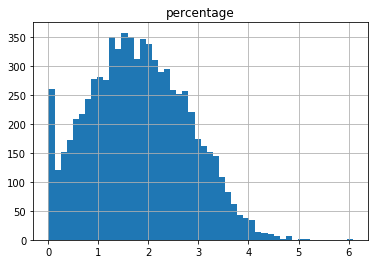

In [44]:
results.hist('percentage', bins = 50)

In [45]:
results[results['percentage'] >= 5]

,date,close_mean,close_sd,open_mean,open_sd,high_mean,high_sd,low_mean,low_sd,close_lr_open_lr_cov,...,change_oi,avg_atmError,ts_atr,prevOp,ttm,atmError,strike,spot,opPrice,percentage
122,2015-01-29,0.002404,0.019669,0.001221,0.017124,0.002450,0.013225,0.001367,0.015723,0.003744,...,1.630435,0.981438,1.026698,0.138880,56,1.021167,900,929.40,71.4,5.169462
141,2015-02-04,0.004401,0.017405,0.006051,0.015814,0.004967,0.012382,0.005313,0.009910,-0.006756,...,-2.366864,0.988893,1.025817,0.170417,50,1.020737,900,928.80,69.5,5.031900
1541,2016-01-18,0.001297,0.019301,0.004447,0.010181,0.004295,0.010493,0.001255,0.016414,-0.007716,...,0.000000,1.027766,1.025697,0.155249,10,1.024344,980,1016.85,91.5,6.083937
2783,2016-09-01,0.001885,0.015109,0.002771,0.013493,0.003696,0.010437,0.002217,0.012068,0.006292,...,100.000000,1.022583,1.021418,0.147073,28,1.025626,990,1029.20,78.1,5.140502


In [43]:
filepath = '/home/docboy/Desktop/Option_Pricing/datasets/'

results.to_csv(filepath + 'REL_feature_set_COV_STEP_1_SCALED.csv', index = False)



# results.to_csv(filepath + 'NIFTY50_feature_set_COV_STEP_1.csv', index = False)